# Zuora/Eloqua export/import service

Zuora export?


In [ ]:
var util = require('util');
var request = util.promisify(require('request'));
var xlsx = require('xlsx');

function zuoraOauth(credentials) {
    var rest_api, rest_user, rest_pass;
}

function zuoraBulkExport(query, zuoraConfig) {
    return request({
        followAllRedirects: true,
        uri: zuoraConfig.rest_api_url + '/object/export',
        json: query,
        method: 'POST',
        headers: {
            'Content-Type': 'application/json',
            'apiAccessKeyId': zuoraConfig.rest_api_user,
            'apiSecretAccessKey': zuoraConfig.rest_api_password,
        }
    }).then(r => r.body.Id)
}

function zuoraBulkExportStatus(exportId, zuoraConfig) {
    return request({
        followAllRedirects: true,
        uri: zuoraConfig.rest_api_url + '/object/export/' + exportId,
        method: 'GET',
        headers: {
            'Content-Type': 'application/json',
            'apiAccessKeyId': zuoraConfig.rest_api_user,
            'apiSecretAccessKey': zuoraConfig.rest_api_password,
        }
    }).then(r => {
        if(r.headers['content-type'].indexOf('application/json') > -1) {
            r.body = JSON.parse(r.body);
        }
        if (r.body.Status === 'Completed') {
            return r.body.FileId;
        } else if (r.body.Status === 'Processing') {
            return new Promise(resolve => setTimeout(resolve, 500))
                .then(() => zuoraBulkExportStatus(exportId, zuoraConfig));
        } else {
            throw new Error('Export status error ' + r.statusCode + ' ' + r.body.Status);
        }
    });
}

function zuoraBulkExportFile(fileId, zuoraConfig) {
    return request({
        followAllRedirects: true,
        uri: zuoraConfig.rest_api_url + '/files/' + fileId,
        method: 'GET',
        headers: {
            'Content-Type': 'application/json',
            'apiAccessKeyId': zuoraConfig.rest_api_user,
            'apiSecretAccessKey': zuoraConfig.rest_api_password,
        }
    }).then(r => r.body)
}

function csvToJson(csv) {
    const workbook = xlsx.read(new Buffer(csv), {type:"buffer"});
    return xlsx.utils.sheet_to_json(workbook.Sheets[workbook.SheetNames[0]]);
}

function mapDataToFields() {
    
}

module.exports = {
    mapDataToFields,
    csvToJson,
    zuoraBulkExport,
    zuoraBulkExportFile,
    zuoraBulkExportStatus,
    zuoraOauth,
}


Test zuora?


In [ ]:
var assert = require('assert');
var fs = require('fs');
var xlsx = require('xlsx');

var PROFILE_PATH = process.env.HOME || process.env.HOMEPATH || process.env.USERPROFILE;

describe('zuora to eloqua', () => {
    beforeEach(() => {
        var workbook = xlsx.readFile(PROFILE_PATH + '/Documents/asm/Marketing_File_Oct_.xlsx');
        var worksheet = xlsx.utils.sheet_to_json(workbook.Sheets[workbook.SheetNames[0]]);

    })
    
    it('should have comparable records', () => {
    })
    
    it('should transfer data end-to-end', () => {
        /*
        var success = eloquaBulkImport(
            mapDataToFields(
                csvToJson(
                    zuoraExport(
                        zuoraOauth()))), eloquaOauth());
        assert(success);
        */
    })
})

describe('zuora oauth', () => {
    var zuoraConfig = JSON.parse(fs.readFileSync(PROFILE_PATH + '/.credentials/zuoraRest_sandbox.json').toString());
    const getQuery = importer.import('zuora query');
    
    it('should connect to zuora using oauth', (done) => {
        zuoraBulkExport(getQuery('beginning of October', 'beginning of November'), zuoraConfig)
            .then(r => {
                assert(r);
                done();
            })
    })
    
    it('should wait for the export to complete', (done) => {
        zuoraBulkExport(getQuery('first of October', 'first of November'), zuoraConfig)
            .then(exportId => zuoraBulkExportStatus(exportId, zuoraConfig))
            .then(r => {
                assert(r);
                done();
            })
    })
    
    it('should download the csv file', (done) => {
        zuoraBulkExport(getQuery('first of October', 'first of November'), zuoraConfig)
            .then(exportId => zuoraBulkExportStatus(exportId, zuoraConfig))
            .then(fileId => zuoraBulkExportFile(fileId, zuoraConfig))
            .then(r => {
                assert(r.length > 0);
                done();
            })
    })
    
    it('should convert CSV to JSON', (done) => {
        zuoraBulkExport(getQuery('first of October', 'first of November'), zuoraConfig)
            .then(exportId => zuoraBulkExportStatus(exportId, zuoraConfig))
            .then(fileId => zuoraBulkExportFile(fileId, zuoraConfig))
            .then(r => csvToJson(r))
            .then(r => {
                assert(r.length > 0);
                done();
            })
    })
})

describe('map zuora data fields', () => {
    it('should map basic data', () => {
        
    })
    
    it('should map contact data', () => {
        
    })
    
    it('should map support data', () => {
        
    })
    
    it('should map cancelled data', () => {
        
    })
})



Generate some charts to explain the zuora data

53
1151
[ [ { 'Account.Id': '2c92a0f951381fed0151613185996512',
      'Account.Name': 'Flight Safety Foundation',
      'Account.AccountNumber': 'A00050256',
      'Account.resellerofRecord__c': '411062925 ACT TODAY PTY LTD',
      'Account.renewalRep__c': 'greg.weimer@swiftpage.com',
      'Account.commisionedSalesRep__c': 'greg.weimer@swiftpage.com',
      'Account.CreatedDate': '12/1/15',
      'SoldToContact.WorkEmail': 'miller@flightsafety.org',
      'SoldToContact.Country': 'Australia',
      'BillToContact.WorkEmail': 'miller@flightsafety.org',
      'RatePlanCharge.Id': '2c92a0fc5aff175f015b12e95df61e20',
      'RatePlanCharge.BillingPeriod': 'Annual',
      'RatePlanCharge.Description': 'Act! Premium - Annual Subscription',
      'RatePlanCharge.Quantity': '2',
      'RatePlanCharge.Version': '2',
      'RatePlanCharge.CreatedDate': '3/27/17',
      'RatePlanCharge.EffectiveEndDate': '11/30/17',
      'ProductRatePlan.planType__c': 'UserLicense',
      'ProductRatePlan.planSu

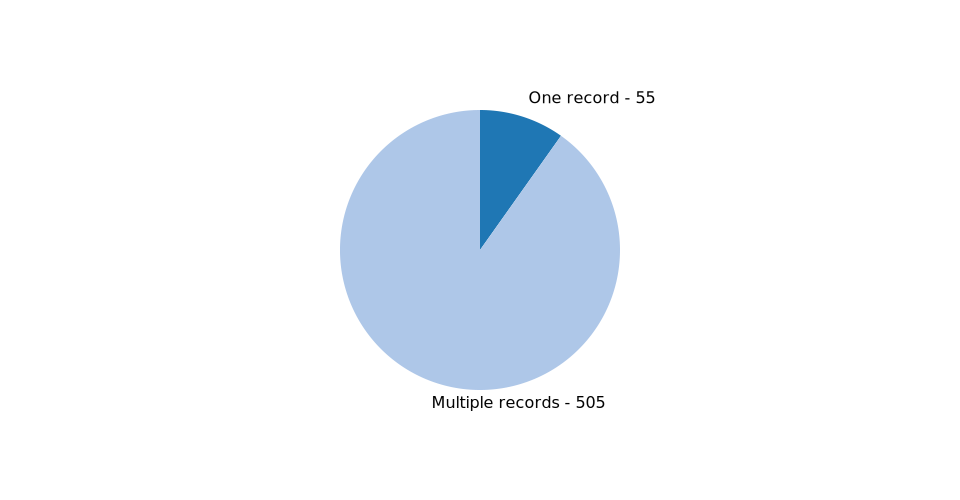

In [ ]:
var importer = require('../Core');
var _ = require('lodash');
var d3PieChart = importer.import('d3 pie chart');
var {
    zuoraBulkExport,
    zuoraBulkExportStatus,
    zuoraBulkExportFile,
    csvToJson
} = importer.import('zuora export');
var getQuery = importer.import('zuora query');
var xlsx = require('xlsx');

var PROFILE_PATH = process.env.HOME || process.env.HOMEPATH || process.env.USERPROFILE;
var zuoraConfig = JSON.parse(fs.readFileSync(PROFILE_PATH + '/.credentials/zuoraRest_production.json').toString());

var october;
function getOctober() {
    return zuoraBulkExport(getQuery('first of November', 'first of December'), zuoraConfig)
        .then(exportId => zuoraBulkExportStatus(exportId, zuoraConfig))
        .then(fileId => zuoraBulkExportFile(fileId, zuoraConfig))
        .then(r => csvToJson(r))
        .then(r => (october = r))
}
var workbook = xlsx.readFile(PROFILE_PATH + '/Documents/asm/Marketing_File_Nov_.xlsx');
var worksheet = xlsx.utils.sheet_to_json(workbook.Sheets[workbook.SheetNames[0]]);


$$.async();
(typeof october === 'undefined' ? getOctober() : Promise.resolve(october))
    .then(r => {
        var solds = worksheet.map(r => (r['Sold To Email'] || '').toLowerCase()),
            bills = worksheet.map(r => (r['Bill To Email'] || '').toLowerCase());
    
        const diff = r.filter(c => solds.indexOf((c['BillToContact.WorkEmail'] || '').toLowerCase()) === -1
                              && solds.indexOf((c['SoldToContact.WorkEmail'] || '').toLowerCase()) === -1
                              && bills.indexOf((c['BillToContact.WorkEmail'] || '').toLowerCase()) === -1
                              && bills.indexOf((c['SoldToContact.WorkEmail'] || '').toLowerCase()) === -1);
    
        //console.log(diff.slice(10, 13))
        console.log(diff.length);
        console.log(r.length)
        /*
        $$.svg(d3PieChart([
            {
                label: 'matching',
                value: r.length - diff.length
            },
            {
                label: 'not matching',
                value: diff.length
            }
        ]), true)
    
        var apc = r.filter(c => c['RatePlanCharge.Description'].toLowerCase().indexOf('cloud') > -1)
        var premium = r.filter(c => c['RatePlanCharge.Description'].toLowerCase().indexOf('premium') > -1)
        var pro = r.filter(c => c['RatePlanCharge.Description'].toLowerCase().indexOf('pro') > -1)
        var unknown = r.filter(c => apc.indexOf(r) === -1 && premium.indexOf(r) === -1 && pro.indexOf(r) === -1)
        $$.svg(d3PieChart([
            {
                label: 'APC',
                value: apc.length
            },
            {
                label: 'Act Premium',
                value: premium.length
            },
            {
                label: 'Act Pro',
                value: pro.length
            },
            {
                label: 'Unknown',
                value: unknown.length
            }
        ]), true)
    
        var annualSupport = r.filter(c => c['RatePlanCharge.Description'].toLowerCase().indexOf('annual') > -1 && c['RatePlanCharge.Description'].toLowerCase().indexOf('support') > -1)
        var monthlySupport = r.filter(c => c['RatePlanCharge.Description'].toLowerCase().indexOf('support') > -1 && annualSupport.indexOf(c) === -1)
        var noSupport = r.filter(c => monthlySupport.indexOf(c) === -1 && annualSupport.indexOf(c) === -1)
        $$.svg(d3PieChart([
            {
                label: 'Monthly support',
                value: monthlySupport.length
            },
            {
                label: 'Annual support',
                value: annualSupport.length
            },
            {
                label: 'No support',
                value: diff.length
            }
        ]), true)
    */
        var grouped = _.groupBy(r, c => c['Account.Id']);
        var singleRecords = Object.keys(grouped).filter(k => grouped[k].length === 1);
        var multiRecords = Object.keys(grouped).filter(k => grouped[k].length > 1);
    
        console.log(singleRecords.slice(0, 3).map(k => grouped[k]))
        console.log(multiRecords.slice(0, 3).map(k => grouped[k]))
    
        $$.svg(d3PieChart([
            {
                label: 'One record',
                value: singleRecords.length
            },
            {
                label: 'Multiple records',
                value: multiRecords.length
            }
        ]), true)
    })
    .catch(e => $$.sendError(e))

Zuora query?


In [ ]:
var moment = require('moment');
var chrono = require('chrono-node');
var excludedRatePlans = [
    'Act! Pro - New License',
    'Act! Pro - 30 Day Support',
    'Act! Pro - Upgrade License',
    'Act! Password Reset Charge',
    'Act! Premium Cloud - Trial',
    'Act! Pro V19 - Upgrade License',
]
var excludedProductSkus = [
    '00000006'
]
var currencies = [
    'USD',
    'AUD',
    'NZD',
]


/*
GET_MODIFIED_SUBSCRIPTIONS,
from.ToString("yyyy-MM-dd"),
to.ToString("yyyy-MM-dd"),
DateTime.Now.ToString("yyyy-MM-dd"),
string.Join("' AND ProductRatePlan.Name!='", renewalsServiceConfiguration.ProductExclusions),
string.Join("' AND Product.SKU!='", renewalsServiceConfiguration.SkuExclusions),
string.Join("' OR Account.Currency='", renewalsServiceConfiguration.CurrencyInclusions)
*/

var query = `SELECT
    Account.Id,
    Account.Name,
    Account.AccountNumber,
    Account.resellerofRecord__c,
    Account.renewalRep__c,
    Account.commisionedSalesRep__c,
    Account.CreatedDate,
    SoldToContact.WorkEmail,
    SoldToContact.Country,
    BillToContact.WorkEmail,
    RatePlanCharge.Id,
    RatePlanCharge.BillingPeriod,
    RatePlanCharge.Description,
    RatePlanCharge.Quantity,
    RatePlanCharge.Version,
    RatePlanCharge.CreatedDate,
    RatePlanCharge.EffectiveEndDate,
    ProductRatePlan.planType__c,
    ProductRatePlan.planSubType__c,
    Product.productType__c,
    Subscription.Name,
    Subscription.Status,
    Subscription.Reseller__c,
    Subscription.SubscriptionEndDate,
    Subscription.SubscriptionStartDate,
    Subscription.TermStartDate,
    Subscription.TermEndDate,
    Subscription.AutoRenew
FROM RatePlanCharge
WHERE Subscription.Status!='Draft' AND Subscription.Status!='Expired'
    AND Subscription.TermEndDate &gt;='{0}' AND Subscription.TermEndDate &lt;='{1}'
    AND (RatePlanCharge.EffectiveEndDate &gt;='{2}' OR RatePlanCharge.ChargeType='OneTime')
    AND (Account.Currency='{5}')
    AND (Product.SKU!='{4}')
    AND (ProductRatePlan.Name!='{3}')
    AND RatePlanCharge.BillingPeriod!='Month'`

.replace('{3}', excludedRatePlans.join("' AND ProductRatePlan.Name!='"))
.replace('{4}', excludedProductSkus.join("' AND Product.SKU!='"))
.replace('{5}', currencies.join("' OR Account.Currency='"))

function getQuery(start, end) {
    return {
        Query: query.replace('{0}', moment(chrono.parseDate(start)).format('YYYY-MM-DD'))
                    .replace('{1}', moment(chrono.parseDate(end)).format('YYYY-MM-DD'))
                    .replace('{2}', moment(new Date()).format('YYYY-MM-DD')),
        Format: 'csv',
        Zip: false
    };
}
module.exports = getQuery;


bulk import eloqua?


In [ ]:
'use stict';

var url = require('url');
var https = require('https');
var request = (options) => new Promise((resolve) => {
    options.timeout = 1000;
    options.url = url.parse(options.uri);
    Object.assign(options, options.url);
    if(typeof options.json !== 'undefined') {
        options.method = 'POST';
        Object.assign(options.headers || {}, {
            'Content-Type': 'application/json'
        })
    } else {
        options.method = 'GET';
    }
    const req = https.request(options, (res) => {
        var data = ''
        var isJson = (res.headers['content-type'] || '').indexOf('application/json') > -1;
        res.setEncoding('utf8');
        res.on('data', (chunk) => {
            data += chunk;
        });
        res.on('end', () => {
            if(isJson) {
                res.body = JSON.parse(data);
            } else {
                res.body = data;
            }
            resolve(res)
        });
    });
    req.on('error', (e) => {
        console.log(`problem with request: ${e.message}`);
    });
    if(typeof options.json !== 'undefined') {
        req.write(JSON.stringify(options.json));
    }
    req.end();
});

var token, expires;
function eloquaOauth(eloquaConfig) {
    if (typeof eloquaConfig === 'undefined'
        || eloquaConfig === null
        || typeof eloquaConfig.rest_api_company === 'undefined'
        || typeof eloquaConfig.rest_api_user === 'undefined'
        || typeof eloquaConfig.rest_api_password === 'undefined'
        || typeof eloquaConfig.rest_client_id === 'undefined'
        || typeof eloquaConfig.rest_secret === 'undefined') {
        throw new Error('Please supply valid config eloqua configuration.');
    }
    var authBody = {
        "grant_type": "password",
        "scope": "full",
        "username": eloquaConfig.rest_api_company + '\\' + eloquaConfig.rest_api_user,
        "password": eloquaConfig.rest_api_password
    };
    return request({
        followAllRedirects: true,
        uri: eloquaConfig.token_uri,
        method: 'POST',
        json: authBody,
        headers: {
            'Authorization': "Basic " + new Buffer(eloquaConfig.rest_client_id + ":" + eloquaConfig.rest_secret).toString("base64")
        }
    })
        .then(res => {
            token = res.body.access_token;
            res.body['expires'] = expires = (new Date()).getTime() + parseFloat(res.body.expires_in) * 1000;
            return res.body;
        });
}

function eloquaBulkImportStatus(syncUri, eloquaToken, eloquaConfig) {
    return request({
        followAllRedirects: true,
        uri: eloquaConfig.rest_api_url + '/bulk/2.0' + syncUri,
        method: 'GET',
        headers: {
            'Authorization': "Bearer " + eloquaToken.access_token
        }
    }).then(r => {
        if (r.body.status === 'success') {
            return true;
        } else if (r.body.status === 'active' || r.body.status === 'pending') {
            return new Promise(resolve => setTimeout(resolve, 500))
                .then(() => eloquaBulkImportStatus(syncUri, eloquaToken, eloquaConfig));
        } else {
            throw new Error('Sync status error ' + r.statusCode + ' ' + r.body.status);
        }
    });
}

function eloquaBulkImportSync(importUri, eloquaToken, eloquaConfig) {
    return request({
        followAllRedirects: true,
        uri: eloquaConfig.rest_api_url + '/bulk/2.0/syncs',
        method: 'POST',
        json: {
            syncedInstanceUri: importUri
        },
        headers: {
            'Authorization': "Bearer " + eloquaToken.access_token
        }
    }).then(r => {
        const syncUri = r.body.uri;
        return eloquaBulkImportStatus(syncUri, eloquaToken, eloquaConfig);
    });
}

function eloquaBulkImportData(json, importUri, eloquaToken, eloquaConfig) {
    return request({
        followAllRedirects: true,
        uri: eloquaConfig.rest_api_url + '/bulk/2.0' + importUri + '/data',
        method: 'POST',
        json: json,
        headers: {
            'Authorization': "Bearer " + eloquaToken.access_token
        }
    });
}

function eloquaBulkImport(eloquaToken, eloquaConfig, instance, execution) {
    if (typeof instance !== 'undefined' && instance !== null && instance.trim() !== '') {
        eloquaConfig.createTemplate.fields["Content"] = (typeof execution !== 'undefined' && execution !== null && execution.trim() !== '')
            ? `{{ContentInstance(${instance})}}`
            : `{{ContentInstance(${instance}).Execution[${execution}]}}`;
    }
    return request({
        followAllRedirects: true,
        uri: eloquaConfig.rest_api_url + '/bulk/2.0/contacts/imports',
        method: 'POST',
        json: eloquaConfig.createTemplate,
        headers: {
            'Authorization': "Bearer " + eloquaToken.access_token
        }
    }).then(res => res.body.uri);
}


module.exports = {
    eloquaBulkImport,
    eloquaBulkImportData,
    eloquaBulkImportSync,
    eloquaBulkImportStatus,
    eloquaOauth
}


test eloqua?

In [ ]:

describe('eloqua bulk upload', () => {
    var eloquaToken, eloquaConfig;
    
    beforeEach(() => {
        try {
            eloquaConfig = JSON.parse(fs.readFileSync(PROFILE_PATH + '/.credentials/eloqua_production.json').toString().trim());
            eloquaToken = JSON.parse(fs.readFileSync(PROFILE_PATH + '/.credentials/eloqua_token.json').toString().trim());
        } catch (e) {
        }
    })
    
    it('should get a valid oauth token', (done) => {
        Promise.resolve(typeof eloquaToken !== 'undefined'
                        && eloquaToken.expires > (new Date()).getTime()
                        ? eloquaToken
                        : eloquaOauth(eloquaConfig))
            .then(r => {
                eloquaToken = r;
                fs.writeFileSync(
                        PROFILE_PATH + '/.credentials/eloqua_token.json',
                        JSON.stringify(r, null, 4));
                assert(r.expires > (new Date()).getTime());
                done();
            })
    })
    
    it('should create a bulk import instance', (done) => {
        eloquaBulkImport(eloquaToken, eloquaConfig)
            .then(r => {
                assert(r.indexOf('/imports/') > -1);
                done();
            })
    })
    
    it('should update data to eloqua', (done) => {
        eloquaBulkImport(eloquaToken, eloquaConfig)
            .then(r => {
                const importUri = r;
                return eloquaBulkImportData([
                    {
                    "EmailAddress": "brian.cullinan@swiftpage.com",
                    "RenewalsStatus": "Drew loves marketing tooooo!"
                    }
                ], importUri, eloquaToken, eloquaConfig)
            })
            .then(r => {
                assert(r.statusCode === 204, 'invalid status recieved from import ' + r.statusCode);
                done();
            })
    })
    
    it('should verify upload was successful', (done) => {
        var importUri;
        eloquaBulkImport(eloquaToken, eloquaConfig)
            .then(r => {
                importUri = r;
                return eloquaBulkImportData([
                    {
                    "EmailAddress": "brian.cullinan@swiftpage.com",
                    "RenewalsStatus": "Drew loves marketing tooooo!"
                    }
                ], importUri, eloquaToken, eloquaConfig)
            })
            .then(r => eloquaBulkImportSync(importUri, eloquaToken, eloquaConfig))
            .then(r => {
                assert(r === true);
                done();
            })
    })
    
    it('should transfer data end-to-end', (done) => {
        var importUri;
        Promise.resolve(typeof eloquaToken !== 'undefined' && eloquaToken.expires > (new Date()).getTime()
            ? eloquaToken
            : eloquaOauth(eloquaConfig))
            .then(r => {
                eloquaToken = r;
            })
            .then(() => eloquaBulkImport(eloquaToken, eloquaConfig))
            .then(r => {
                importUri = r;
                return eloquaBulkImportData([
                    {
                    "EmailAddress": "brian.cullinan@swiftpage.com",
                    "RenewalsStatus": "Drew loves marketing tooooo!"
                    }
                ], importUri, eloquaToken, eloquaConfig);
            })
            .then(() => eloquaBulkImportSync(importUri, eloquaToken, eloquaConfig))
            .then(() => done())
    })
})